In [1]:
#importing packages and dataset
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
pd.set_option("display.max_rows", None, "display.max_columns", None)

df=pd.read_csv(r'/Users/cecylia/Desktop/Job/data sci/portfolio/Mining/MN_mining_data.csv')
df.head()

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
0,9175100,rock,-93.16750,48.60222,11/14/00,united_states_geological_survey,NaN,metasediment,21.0,36.0,75
1,9175101,rock,-93.16750,48.60222,11/14/00,united_states_geological_survey,NaN,NaN,29.0,198.0,44
2,9175102,rock,-93.11861,48.60639,11/14/00,united_states_geological_survey,NaN,NaN,11.0,91.0,18
3,9175103,rock,-93.11861,48.60639,11/14/00,united_states_geological_survey,NaN,NaN,17.0,63.0,32
4,9175104,rock_outcrop,92.70556,-48.51444,11/14/00,united_states_geological_survey,NaN,metasediment,18.0,28.0,77


Taking a first look at the data I already see some issues just looking at the first five rows, such as missing values. Lets take a closer glace by looking at the info to see what kind of data types we are dealing with and how many values may be missing.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          305 non-null    int64  
 1   medium          305 non-null    object 
 2   easting_wgs84   305 non-null    float64
 3   northing_wgs84  304 non-null    float64
 4   date_assay      305 non-null    object 
 5   company         305 non-null    object 
 6   structure       110 non-null    object 
 7   lithology       289 non-null    object 
 8   Co_ppm          302 non-null    float64
 9   Cu_ppm          242 non-null    float64
 10  Ni_ppm          305 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 26.3+ KB


In [3]:
df.describe()

,sample,easting_wgs84,northing_wgs84,Co_ppm,Cu_ppm
count,3.050000e+02,305.000000,304.000000,302.000000,242.000000
mean,9.375963e+06,-87.463830,44.920253,46.256391,117.286674
std,1.101207e+05,27.064142,18.343611,70.558872,9115.185410
min,9.175100e+06,-93.350000,-93.200000,-0.100000,-99999.000000
25%,9.278678e+06,-92.406940,47.587293,7.500000,12.500000
50%,9.334338e+06,-91.925830,47.816670,24.200000,38.000000
75%,9.497293e+06,-91.116670,48.143752,46.150000,96.750000
max,9.500207e+06,92.936110,48.666670,768.000000,99999.000000


It looks like there are quite a bit of null values to deal with-luckily most of the missing values are on columns that we don't need to answer the final question. There are some columns that should be floats/integers, but are object. After doing summary stats on floats/integer columns I see some lat and longs that dont make sense such as positive 92.94 for long and -93 for lat. This dataset is for MN so this is not possible. We will need to fix this as well. There are also some neagtive Co and Cu values that need to be fixed, as well as some 99999's which indicates NaN most likely. After taking a look at the null value sum of each column I will start cleaning the problematic columns.

In [4]:
df.isna().sum().sort_values(ascending=False)

structure         195
Cu_ppm             63
lithology          16
Co_ppm              3
northing_wgs84      1
sample              0
medium              0
easting_wgs84       0
date_assay          0
company             0
Ni_ppm              0
dtype: int64

I am going to create a function that looks for unique values for each column to see how many unique values there are in a column. This is great for columns that shouldn't have a lot of unique values (such as lithology) and columns that should have a unique value for each entry (such as sample). This will make spotting small errors a lot easier.

In [5]:
#custom function
def count_unique(df):
    """Returns a single value of how many unique values there are in the dataframe column"""
    count=df.nunique()
    return count

Let's start with the most important columns we need to answer our question. I am going to start with the lithology column and apply our created function.

In [6]:
#how many different lithologies in lithology column
count_unique(df['lithology'])

35

That's a lot of lithologies! Let's see what's going on and also explore the 16 nan values as well (indicated by df.info(). Let's create a second function that lists all unique values. I imagine we will need to do this with other columns so creating a funtion will make the task faster.

In [7]:
#custom function
def list_unique(df):
    """Returns all unique values in the dataframe column"""
    values=df.unique()
    values.sort()
    for v in values:
        print(v)

In [8]:
#list of all lithologies in lithology column
df['lithology']=df['lithology'].astype('str')
list_unique(df['lithology'])

Basalt
CHERT
DACITE
GABBRO
GRAYWACKE
andesite
argillite
basalt
basalt.
basaltt
bassalt
dacite
diorite
felsic
gabbro
gabro
granite
granodiorite
greenstone
hornfels
meta-andesite
meta-graywacke
metafelsite
metagraywacke
metasediment
metasiltstone
monzonite
nan
none
pegmatite
rhyolite
sandstone
schist
shale
siliciclastic
tuff


Looks like there are a lot of data entry mistakes such as uppercase/lowercase repeats and spelling mistakes. Also there are a few 'none'. Let's change those to unknown. Let's also change the rest of the nan's to unknown as well for now. We can have a look at the rock formations spatially later to decide if some unknowns can be changed based on location-however this is often not a good idea-especially in complex geological areas. I will also take a look at the range of Co/Ni of these unknowns a little later to decide if the points are even important to the task at hand.

In [9]:
#cleaning up the lithology column by making everything lowercase, filling in unknown, and correcting spelling mistakes
df['lithology'] = df['lithology'].str.lower()
df['lithology'] = df['lithology'].replace('none', 'unknown', regex=False)
df['lithology']=df.lithology.replace(dict.fromkeys(['bassalt','basaltt','basalt.'], 'basalt'))
df['lithology'] = df['lithology'].replace('gabro', 'gabbro', regex=False)
df['lithology'] = df['lithology'].replace('-', '', regex=False)
df['lithology']=df['lithology'].replace('nan', 'unknown')

In [10]:
list_unique(df['lithology'])

andesite
argillite
basalt
chert
dacite
diorite
felsic
gabbro
granite
granodiorite
graywacke
greenstone
hornfels
meta-andesite
meta-graywacke
metafelsite
metagraywacke
metasediment
metasiltstone
monzonite
pegmatite
rhyolite
sandstone
schist
shale
siliciclastic
tuff
unknown


Looks good for now. Let's move on and do something similar to the other columns before dealing with unknown a bit more in depth. Those negative ppm's in Co need to be fixed. I am going to switch them to positive. There are also a few blanks, however we can take a look at those 3 NaN's a little later to decide what to do.

In [11]:
#changing so all values are positive
df['Co_ppm'] = df['Co_ppm'].abs()

Unfortunetly summary stats on Ni could not be done since the datatype is not an integer or float-which of course is also an indication that something is fishy about the data. Let's apply out list unique function on this as well since this is a realively small dataset. 

In [12]:
list_unique(df['Ni_ppm'])

-1.25
1.75
100
1011
105
106.5
11
11.5
110
111
12
12.5
120
1200
124
125
126
130
132
134
138
139
14
140
145
15
150
16
162
165
169
17.5
172
18
180
184.5
188
19
190
195
196
2
2.5
20
201
214.5
22
23
232
240
242
247.5
25
252
254
26
260
270
277
29
3.75
3.9
30
300
32
34
35
351
36
364.5
37.5
381
40
41
42
43
430
44
440
45
450
46
470
48
5
5.5
5.7
50
500
501
517.5
52
526.5
53
54
55
58
6
6.1
61
618
619.5
62
63
64
640
65
66
67
67.5
68
7
7.5
70
71
73
75
76
77
78
79
8
801
81
82
83
85
86
87
88.5
9
90
91
912
93
934.5
96
98
<1.5


A few issues here. Looking at this closer it looks like the <1.5 is the issue and will just be changed to 1.4 so that we can perform analysis on this column. Also the negative numbers will be changed to positive numbers, just like the Co_ppm column.

In [13]:
#changing values and removing negatives
df['Ni_ppm'] = df['Ni_ppm'].str.replace("<1.5", "1.4", regex=False)
df['Ni_ppm']=df['Ni_ppm'].astype('float')
df['Ni_ppm']=df['Ni_ppm'].abs()

Let's move on to the lat column. There are a lot of issues with this column given the summary stats that were performed earlier. 1)A few lats in the -90s which does not make sense. I have a hunch they are flipped with the longitude column. We will validate this in a little bit. 2)A few negative lats in the 40s which also doesn't make sense. Those - signs will be dropped. I also have a hunch the - sign is missing in the longitude column. We will verify that as well in a little bit. 3)There is a missing value here and no missing values in the longitude column. This type of error can be a little tricky. We will take a closer look at the row in which that value is missing to determine what we can do (drop it because it's not needed or make an assumption based on other columns). Let's take a closer look at this value.

In [14]:
df.loc[df.northing_wgs84.isnull()]

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
299,9500207,rock_outcrop,-91.83333,NaN,8/8/91,united_states_geological_survey,lava flow,basalt,43.8,96.0,254.0


Unfortunetly, this is a basalt entry which makes me hestitant to drop the row. The Ni/Co ppm does look to be pretty low compared to other values I have seen in the dataset. Ultimately, I am deciding to drop this one row.

In [15]:
#dropping the row
df=df.drop(299)

Let's deal with the lat and longs and see what may be flipped due to data entry errors. First, I will double check to make sure these value misplacement/mistakes aligns row to row. Next,  I will change all numbers to positive in the easting column so that I can do a quick swap on all numbers less than 49 in the easting column. Then covert both columns to their correct - and + values.

In [16]:
#checking out the faulty values to see if they all align-looks like they do.
df.loc[df['easting_wgs84']>0]

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
4,9175104,rock_outcrop,92.70556,-48.51444,11/14/00,united_states_geological_survey,NaN,metasediment,18.00,28.0,77.0
21,9177307,rock_outcrop,48.41581,-92.52700,11/6/01,united_states_geological_survey,pluton; stock,granite,3.00,4.0,1.4
30,9262291,rock_outcrop,92.91667,-46.43056,1/11/79,united_states_geological_survey,NaN,schist,33.00,78.0,100.0
33,9262294,rock_outcrop,92.93611,-46.33333,1/11/79,united_states_geological_survey,NaN,schist,15.00,3.2,63.0
70,9278672,rock_outcrop,48.63333,-93.20000,11/14/83,united_states_geological_survey,xenolith,diorite,66.00,43.0,640.0
161,9334348,rock,47.61861,-91.93222,1/2/88,united_states_geological_survey,NaN,gabbro,22.50,75.0,75.0
185,9493009,rock_outcrop,92.13333,-47.85000,8/7/85,united_states_geological_survey,NaN,greenstone,0.10,29.0,67.0
195,9494367,rock_outcrop,90.33333,-47.75000,1/8/87,united_states_geological_survey,lava flow,rhyolite,0.41,53.0,15.0


Just as suspected there are a few lats/longs that belong in the opposite columns due to human entry error. Also a few postive and negative sings that needs to be switched. Lets change all long columns to positive first to make the swap a little easier. Once swapped this will all get changed back to negative.

In [17]:
#changing longs to postive
df['easting_wgs84']=df['easting_wgs84'].abs()

In [18]:
#swapping the values between rows that need to be swapped
swap=df['easting_wgs84']<49.0
df.loc[swap, ['easting_wgs84','northing_wgs84']] = df.loc[swap, ['northing_wgs84','easting_wgs84']].values

In [19]:
#lets finish up by putting a negative sign infront of each long
df['easting_wgs84']=df['easting_wgs84'].abs()
df['easting_wgs84']*=-1

In [20]:
#lets take a look to see if the swap worked out before continue
df.easting_wgs84.describe()

count    304.000000
mean     -91.871750
std        0.991634
min      -93.350000
25%      -92.532750
50%      -91.934860
75%      -91.116670
max      -89.639140
Name: easting_wgs84, dtype: float64

This look good and makes much more sense. Let's change the lat column to positive do a final verification of the column and move on to other columns

In [21]:
#positive sign for each lat
df['northing_wgs84']=df['northing_wgs84'].abs()

In [22]:
#final verification
df.northing_wgs84.describe()

count    304.000000
mean      47.867896
std        0.538143
min       46.333330
25%       47.599860
50%       47.850000
75%       48.150000
max       48.666670
Name: northing_wgs84, dtype: float64

Looks good. Moving on to sample column. I want to make sure there are no duplicate entries so let's take a look.

In [23]:
df.loc[df.duplicated(subset=['sample'], keep=False), :]

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
223,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41.0
233,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,59.0,83.0,172.0
300,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,36.0,110.0,41.0
301,9497345,rock_outcrop,-90.41667,47.75,4/5/89,united_states_geological_survey,lava flow,basalt,52.0,58.0,242.0
302,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41.0
303,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41.0
304,9497291,rock_outcrop,-90.33333,48.00,3/20/89,united_states_geological_survey,lava flow,basalt,42.0,100.0,41.0


It looks like sample 9497291 got entered 4 times by accident. We can drop those duplicates. However, first we need to deal with sample 9497345 which is a bit confusing. It is in the same exact position, however the co/cu/ni ppm's are different. We will assign two of those samples a new ID number just to be safe instead of dropping it. Let's take a look at all unique values  in the sample column so that we can give it a proper unique ID

In [24]:
list_unique(df['sample'])

9175100
9175101
9175102
9175103
9175104
9175105
9175106
9175107
9177294
9177295
9177296
9177297
9177298
9177299
9177300
9177301
9177302
9177303
9177304
9177305
9177306
9177307
9177308
9177309
9177310
9262285
9262286
9262287
9262288
9262290
9262291
9262292
9262293
9262294
9262295
9262296
9262308
9262309
9262310
9262311
9262312
9278638
9278639
9278640
9278641
9278645
9278646
9278647
9278648
9278649
9278652
9278653
9278654
9278655
9278656
9278657
9278658
9278659
9278660
9278661
9278662
9278663
9278664
9278665
9278666
9278667
9278668
9278669
9278670
9278671
9278672
9278673
9278674
9278675
9278676
9278677
9278678
9278679
9278680
9278681
9278682
9278683
9278684
9278685
9278686
9278687
9278688
9278689
9278690
9278691
9332266
9332267
9332268
9332269
9332270
9332271
9332272
9332273
9332274
9332275
9332276
9332277
9332278
9332285
9332286
9332288
9332289
9332290
9332291
9332901
9333148
9333348
9333349
9333351
9333355
9333361
9334243
9334244
9334245
9334247
9334248
9334249
9334250
9334251
9334252


In [25]:
#assign new ID
df.loc[301, 'sample']=9500207

In [26]:
#assigning new ID
df.loc[300, 'sample']=9500208

In [27]:
#dropping the identical rows now
df.drop_duplicates(subset=['sample'], inplace=True)

Just making sure we didn't lose any entries. Looks like three entries in total got dropped which makes sense. Also make sure all duplicates are gone.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 301
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sample          301 non-null    int64  
 1   medium          301 non-null    object 
 2   easting_wgs84   301 non-null    float64
 3   northing_wgs84  301 non-null    float64
 4   date_assay      301 non-null    object 
 5   company         301 non-null    object 
 6   structure       106 non-null    object 
 7   lithology       301 non-null    object 
 8   Co_ppm          298 non-null    float64
 9   Cu_ppm          238 non-null    float64
 10  Ni_ppm          301 non-null    float64
dtypes: float64(5), int64(1), object(5)
memory usage: 28.2+ KB


In [29]:
count_unique(df['sample'])

301

Lets move on to the structure column

In [30]:
df['structure']=df['structure'].astype('str')
count_unique(df['structure'])

11

In [31]:
list_unique(df['structure'])

dike; sill; laccolith
extrusive
lava flow
nan
plug/pipe
pluton
pluton; stock
pyroclastic
sill/laccolith
stock
xenolith


This looks pretty good. Let's just put nan as unknown and move on. While we are not concerned with Cu for this assignment I decided to clean it up a little bit.

In [32]:
df['structure']=df['structure'].replace('nan', 'unknown')

Let's get rid of all negatives in the Cu column, as well as replace '99999' with nan due to error. All nan will remain nan. Normally, I may deal with these nan in a different manner however this column isn't relevant to the current assigment.

In [33]:
df['Cu_ppm']=df['Cu_ppm'].abs()

In [34]:
#replace 99999 with nan
df.Cu_ppm.replace(99999.0, np.nan, inplace=True)

Moving on to the rest of the columns before I start the visual component of the project

In [35]:
list_unique(df['date_assay'])

1/11/79
1/12/79
1/15/91
1/16/91
1/2/88
1/8/87
10/11/77
10/12/89
10/26/90
11/14/00
11/14/83
11/6/01
2/21/85
3/20/89
4/5/89
5/19/86
7/28/87
8/7/85
8/8/84
8/8/91


In [36]:
list_unique(df['medium'])

rock
rock_outcrop


Everything else looks pretty good. Before moving on to answering the question, lets take a final look at the lithology column and decide what to do with all the unknown. First, I want to take a look at some stats. Second, I want to quickly map the data in qgis to see how the points look in relation to one another.

In [37]:
df.groupby('lithology')['Co_ppm', 'Ni_ppm'].agg(['mean','min', 'max'])

/var/folders/11/7dw54ln10md9k5cbk_wjyfy80000gn/T/ipykernel_27479/2181799941.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('lithology')['Co_ppm', 'Ni_ppm'].agg(['mean','min', 'max'])


Co_ppm                     Ni_ppm                
                      mean     min    max        mean     min     max
lithology                                                            
andesite         26.397500   8.590   56.0  124.750000   11.00   430.0
argillite        22.147059  10.300   32.6   61.647059   20.00   140.0
basalt           52.387143   4.970  123.0  150.871429    2.00  1200.0
chert            20.000000  20.000   20.0    9.000000    9.00     9.0
dacite            8.900833   1.810   41.4   20.800000    2.50    93.0
diorite          25.500000   5.000   66.0  158.666667    8.00   640.0
felsic           21.000000  21.000   21.0   21.500000   14.00    29.0
gabbro          152.550000  22.500  768.0  351.060000    7.50  1011.0
granite           4.600000   1.000   17.0    6.920000    1.40    29.0
granodiorite      8.000000   4.000   10.0   24.500000    7.00    46.0
graywacke        14.000000  14.000   14.0   41.000000   41.00    41.0
greenstone        0.100000   0.100    0.1  130.000000   67.00   169.0
hornfels         19.500000  14.000   25.0   41.500000   30.00    53.0
meta-andesite     0.100000   0.100    0.1  126.000000  126.00   126.0
meta-graywacke   17.912500   6.150   29.1   17.000000   11.00    23.0
metafelsite       0.500000   0.500    0.5    3.900000    3.90     3.9
metagraywacke    24.800000  13.000   37.0   54.818182   32.00   130.0
metasediment     16.600000  10.000   21.0   69.800000   41.00    86.0
metasiltstone    23.500000  18.000   29.0   68.000000   45.00    91.0
monzonite        19.000000  19.000   19.0   23.000000   23.00    23.0
pegmatite         1.000000   1.000    1.0    1.400000    1.40     1.4
rhyolite          1.870000   0.120    5.7   20.812500   11.50    35.0
sandstone        22.500000  19.000   26.0   28.000000    6.00    50.0
schist           35.045455  15.000   78.0  136.545455   45.00   470.0
shale            14.666667  13.000   18.0   38.666667   22.00    52.0
siliciclastic    12.137324   0.625   37.5   32.121831    1.25   125.0
tuff             39.550000  39.300   39.8   54.000000   46.00    62.0
unknown          42.694444   4.000  330.0   57.555556   11.00   110.0

I can already tell that gabbro may perhaps be a better prospect, however no conclusions can be made without visuals. Looks like the unknown max is at 330 ppm for Co and 110 ppm for Ni. While losing data is not ideal, we are not losing high ppm points compared to others in the dataset. Also, looking at the map in qgis led me to the conclusion that closest distance imputation for unknowns is not a good idea. The geology in northern MN is very complex and erratic. Let's take a look at those three missing Co_ppm values before moving on.

In [38]:
df.loc[df.Co_ppm.isnull()]

,sample,medium,easting_wgs84,northing_wgs84,date_assay,company,structure,lithology,Co_ppm,Cu_ppm,Ni_ppm
182,9493006,rock_outcrop,-92.16667,47.78333,8/7/85,united_states_geological_survey,unknown,greenstone,NaN,94.0,145.0
187,9493011,rock_outcrop,-92.15000,47.81667,8/7/85,united_states_geological_survey,unknown,greenstone,NaN,55.0,169.0
189,9493013,rock_outcrop,-92.21667,47.80000,8/7/85,united_states_geological_survey,unknown,greenstone,NaN,43.0,139.0


Since these entries are all greenstone let's leave these values as NaN since the task at hand does not concern greenstone lithology. Otherwise, these NaN values would have been imputed. Let's create some geodataframes and do a preliminary plot in python before moving to qgis to create our final map with the raster. I will create two geodataframes-basalt and gabbro.

In [39]:
df_basalt_gabbro=df[(df['lithology']=='basalt') | (df['lithology']=='gabbro')]

In [40]:
#convert dataframe to geodataframe
from pyproj import CRS
crs=CRS('EPSG:4326')
df['geometry']=df.apply(lambda x: Point((x.easting_wgs84, x.northing_wgs84)), axis=1)
df_geo=gpd.GeoDataFrame(df, crs=crs, geometry=df.geometry)

In [41]:
#seperating into two seperate geodataframes
basalt_geo=df_geo[df_geo['lithology']=='basalt']
gabbro_geo=df_geo[df['lithology']=='gabbro']

Text(0.5, 1.0, 'Gabbro Ni_ppm')

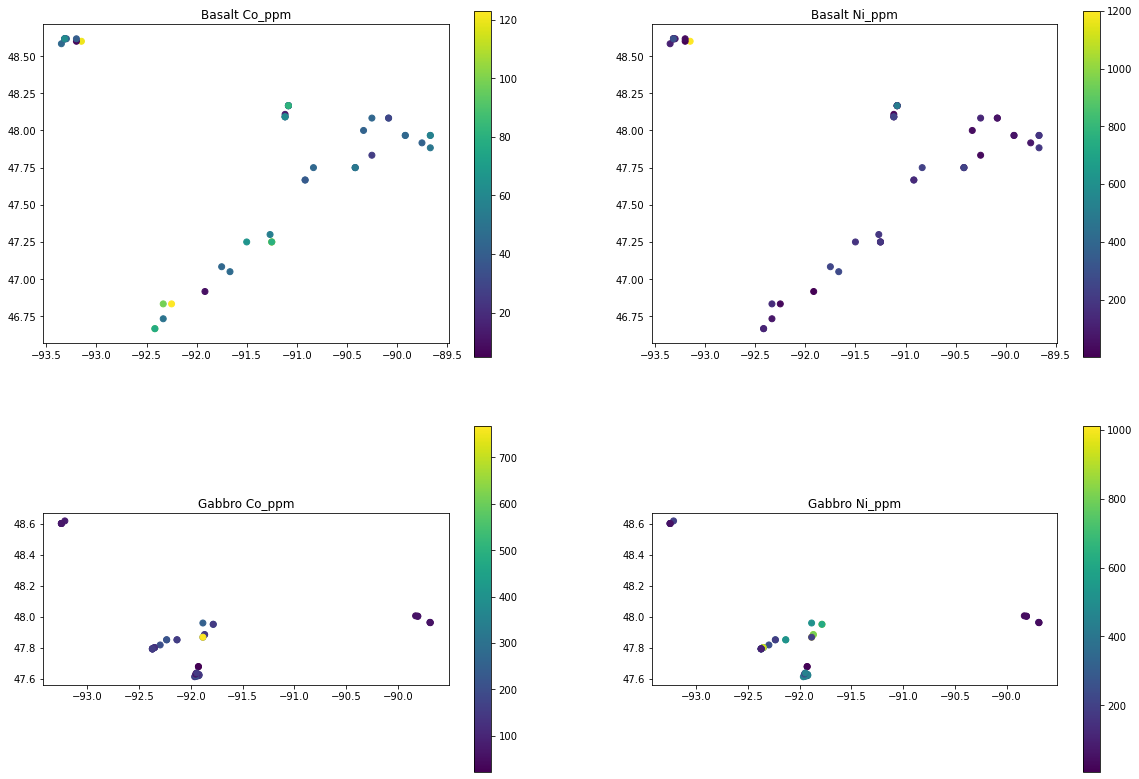

In [42]:
#basalt/gabbro plots
fig, axes=plt.subplots(ncols=2,nrows=2, figsize=(20,14))
basalt_geo.plot(column='Co_ppm',ax=axes[0,0],legend=True)
axes[0,0].set_title('Basalt Co_ppm')
basalt_geo.plot(column='Ni_ppm',ax=axes[0,1], legend=True)
axes[0,1].set_title('Basalt Ni_ppm')
gabbro_geo.plot(column='Co_ppm',ax=axes[1,0], legend=True)
axes[1,0].set_title('Gabbro Co_ppm')
gabbro_geo.plot(column='Ni_ppm',ax=axes[1,1], legend=True)
axes[1,1].set_title('Gabbro Ni_ppm')

I have a pretty good idea of the statistical distrubution and what areas are good targets, however lets move this project to Tableau for final analysis and mapping!